In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import geopandas as gpd
import requests
from requests import get
from urllib.parse import urlparse
from functools import wraps
import matplotlib

In [3]:
lfb_incident = pd.read_csv("LFB Incident data from 2018 onwards.csv", low_memory=False)
lfb_dwelling = lfb_incident[(lfb_incident['PropertyCategory']=='Dwelling') & (lfb_incident['IncidentGroup']=='Fire') & (lfb_incident['CalYear']>=2018)][['IncidentNumber', 'IncidentGroup', 'CalYear', 'PropertyCategory', 'PropertyType', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'Easting_rounded', 'Northing_rounded']]
lfb_gdf = gpd.GeoDataFrame(lfb_dwelling, geometry=gpd.points_from_xy(lfb_dwelling.Easting_rounded, lfb_dwelling.Northing_rounded, crs='epsg:27700'))

In [4]:
path_borough = os.path.join('statistical-gis-boundaries-london', 'ESRI', 'London_Borough_Excluding_MHW.shp')
borough = gpd.read_file(path_borough).to_crs('EPSG:27700')
combined = gpd.sjoin(lfb_gdf, borough, how='inner', predicate='within')
borough_lfb = lfb_gdf.IncGeo_BoroughCode.dropna().value_counts().reset_index()
borough_counts = borough.merge(borough_lfb, left_on='GSS_CODE', right_on='IncGeo_BoroughCode')

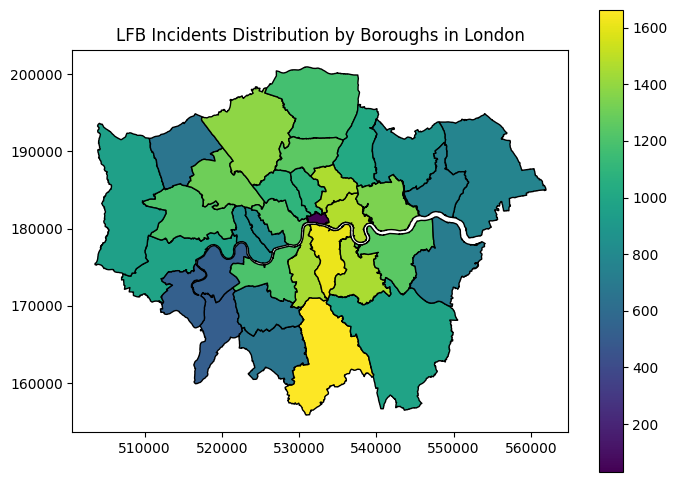

In [5]:
f, ax = plt.subplots(figsize=(8,6))
ax = borough_counts.plot(ax=ax, column="count", cmap="viridis", edgecolor="black", legend=True)
plt.title("LFB Incidents Distribution by Boroughs in London")
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score
dwelling = pd.read_excel('Number_and_density_of_dwellings_by_borough.xlsx', sheet_name='Number of dwellings', skiprows=[1])
population = pd.read_csv('housing-density-borough.csv')
popualtion_2024 = population[population['Year'] == 2024][['Code', 'Name', 'Population']]
borough = borough.merge(dwelling, left_on='GSS_CODE', right_on='ONS code')
borough = borough.merge(popualtion_2024, left_on='GSS_CODE', right_on='Code')
borough_k = borough.merge(borough_lfb, left_on='GSS_CODE', right_on='IncGeo_BoroughCode')
borough_k['dwelling_density'] = borough_k[2019]/borough_k['HECTARES']/100
borough_k['population_density']= borough_k['Population']/borough_k['HECTARES']/100
borough_k['lfb_density']= borough_k['count']/borough_k['HECTARES']/100
borough_k.set_index('GSS_CODE',inplace=True)
sd = StandardScaler()
borough_kmeans = pd.DataFrame(index=borough_k.index)
borough_kmeans[['dwelling_density','population_density','lfb_density']] = borough_k[['dwelling_density','population_density','lfb_density']]
borough_kmeans[['dwelling_density_z','population_densityz_z','lfb_density_z']] = sd.fit_transform(borough_kmeans[['dwelling_density','population_density','lfb_density']])

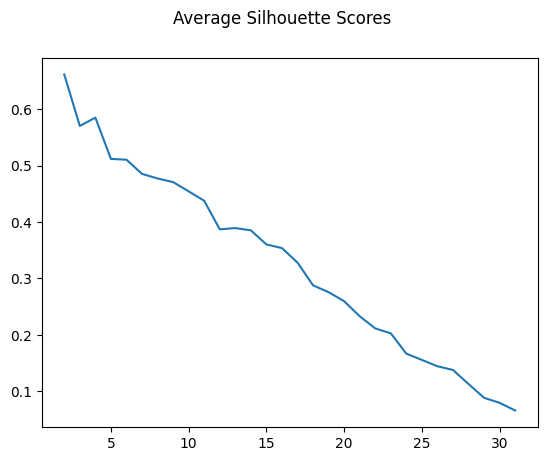

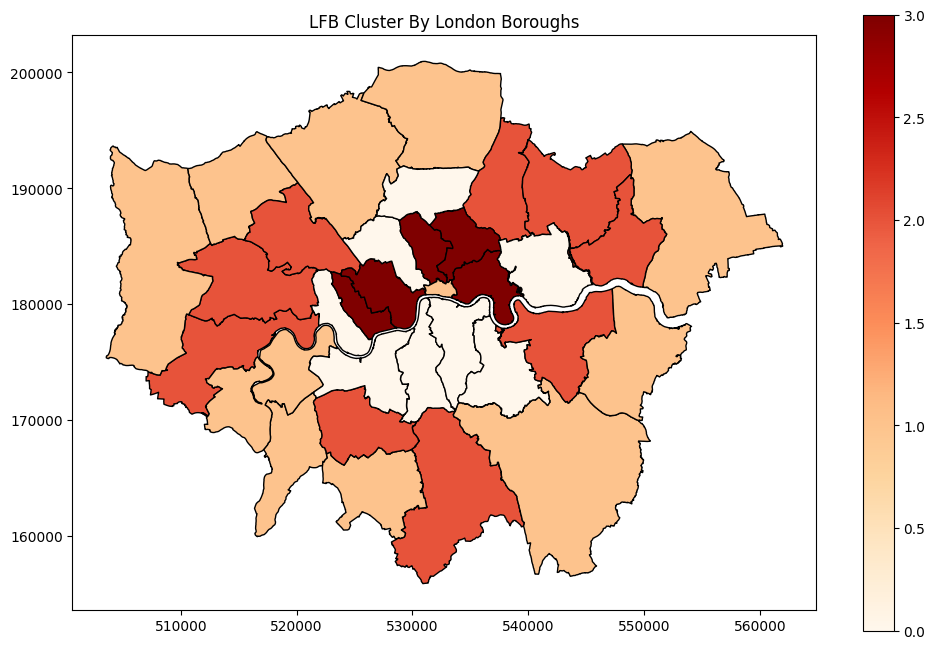

In [12]:
k_range = []
scores = []
cluster_data = borough_kmeans[['dwelling_density_z','population_densityz_z','lfb_density_z']]
for k in range(2,32):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(cluster_data)
    ave_score = silhouette_score(cluster_data, kmeans.labels_)
    k_range.append(k)
    scores.append(ave_score)
plt.plot(k_range, scores)
plt.gcf().suptitle("Average Silhouette Scores");
kmeans = KMeans(n_clusters=4, random_state=42)
borough_kmeans['cluster'] = kmeans.fit_predict(borough_kmeans[['dwelling_density_z','population_densityz_z','lfb_density_z']])
result_clu_lfb = borough_k.merge(borough_kmeans, left_index=True, right_index=True)
f, ax = plt.subplots(figsize=(12,8))
result_clu_lfb.plot(ax=ax, column="cluster", cmap="OrRd", edgecolor="black", legend=True)
plt.title("LFB Cluster By London Boroughs")
plt.show()

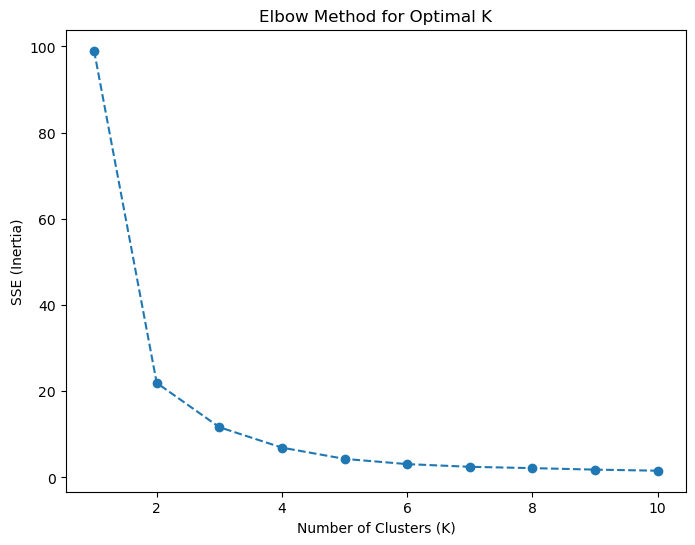

In [14]:
sse = []
k_range = range(1, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(borough_kmeans)
    sse.append(kmeans.inertia_) 

sse_diff = np.diff(sse) 
sse_se = np.std(sse_diff)  

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.show()

In [13]:
cols = ["dwelling_density_x", "population_density_x", "lfb_density_x"]
centroid_boro = pd.DataFrame(columns=cols)
for k in sorted(result_clu_lfb["cluster"].unique()):
    print(f"Processing cluster {k}")
    clust_boro = result_clu_lfb[result_clu_lfb["cluster"]==k]
    centroid_boro.loc[k] = clust_boro[cols].mean()

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3


In [14]:
centroid_boro.head()

,dwelling_density_x,population_density_x,lfb_density_x
0,0.429384,1.094154,0.004479
1,0.151603,0.386326,0.001125
2,0.221455,0.630387,0.002149
3,0.624893,1.478645,0.006804


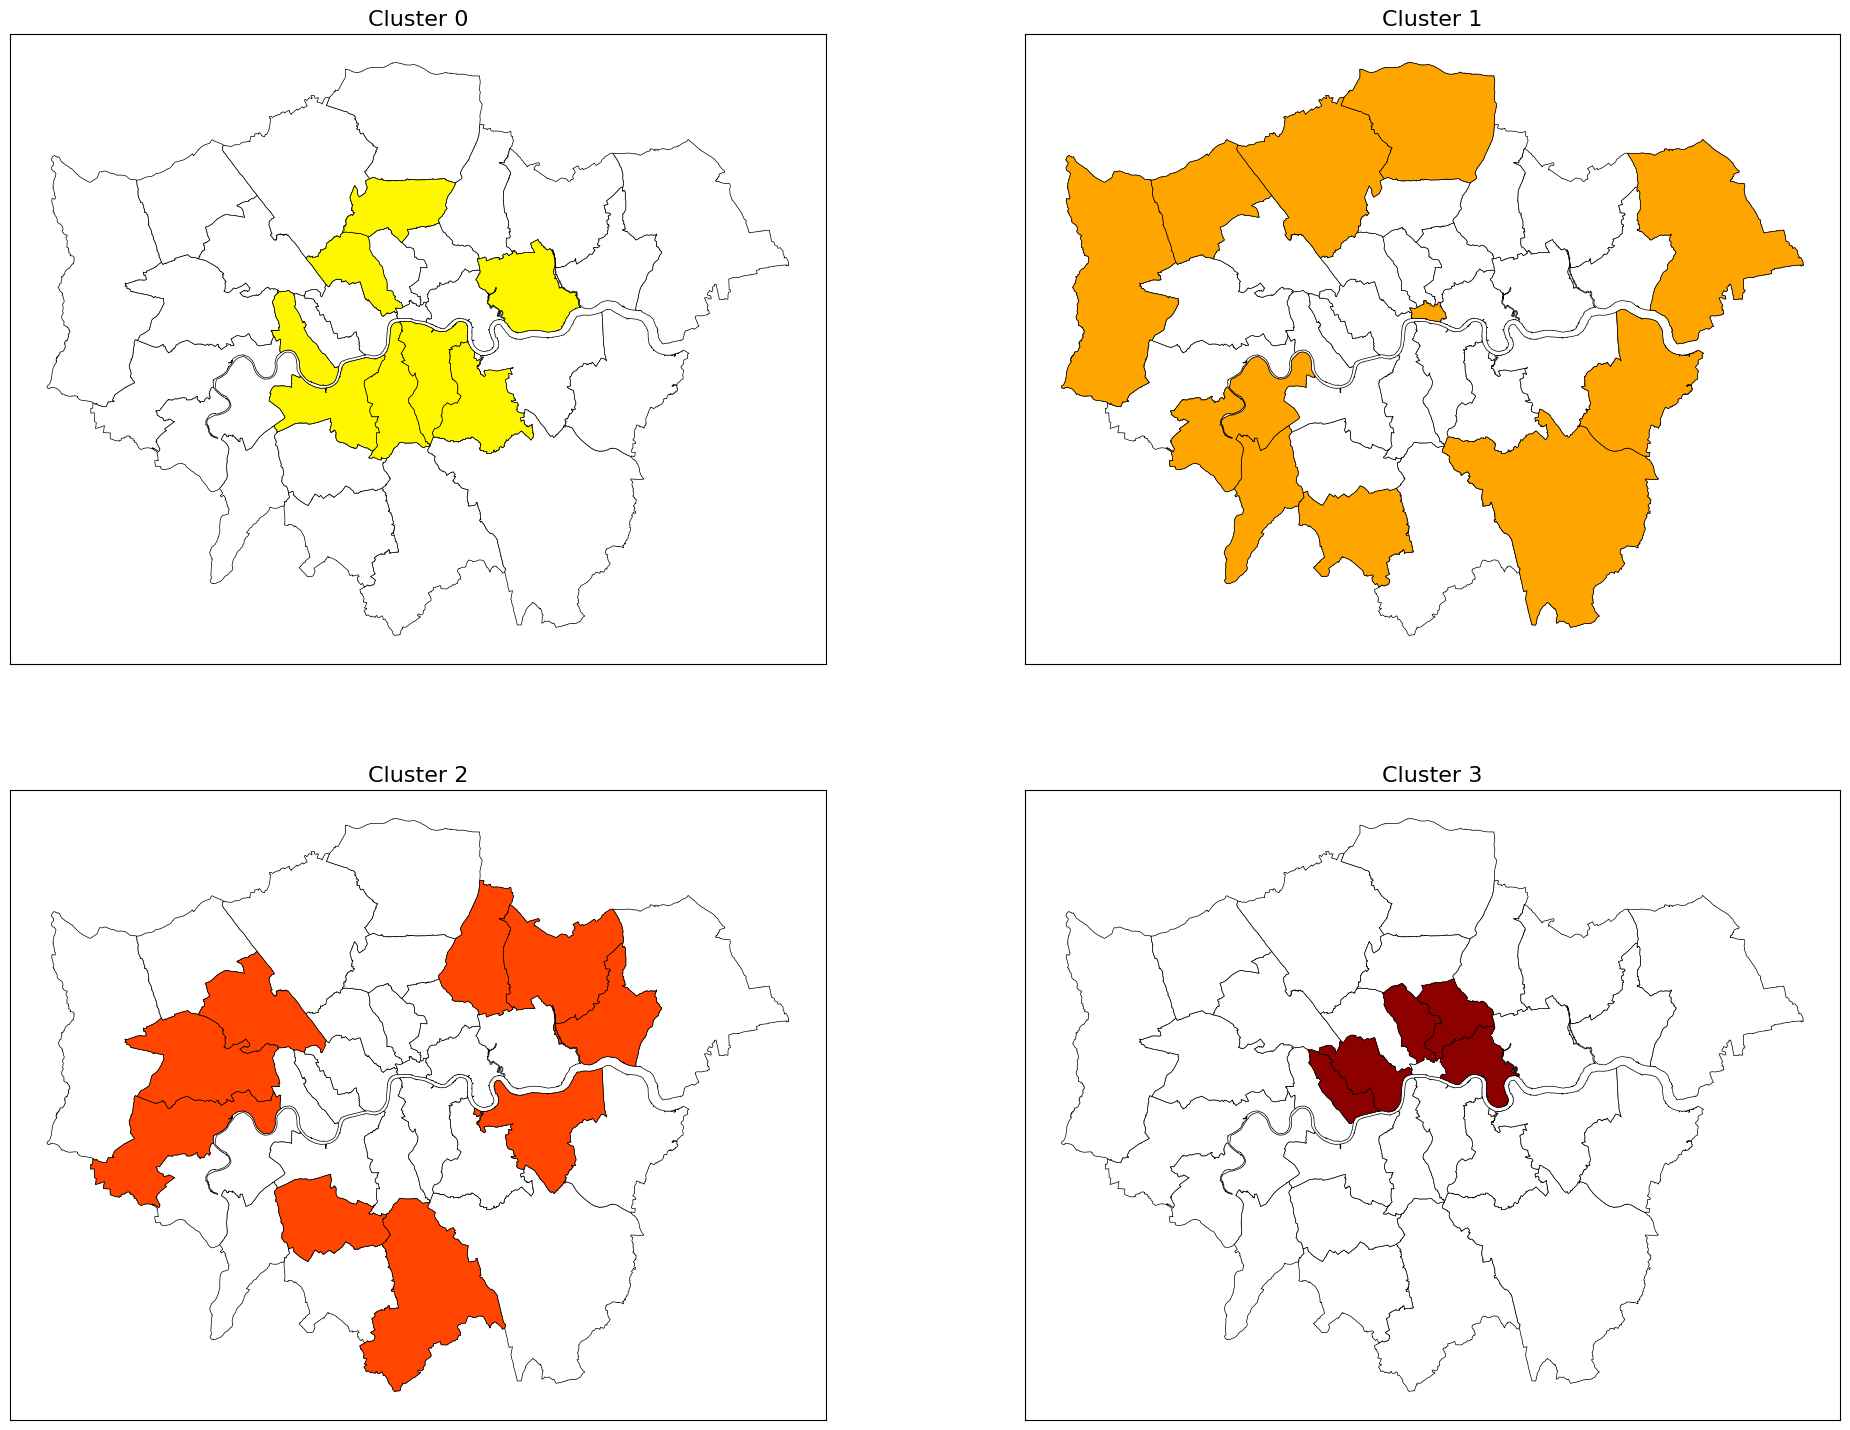

In [162]:
fig, ax = plt.subplots(2,2,figsize=(24,18))
result_clu_lfb0=result_clu_lfb[result_clu_lfb['cluster']==0]
result_clu_lfb1=result_clu_lfb[result_clu_lfb['cluster']==1]
result_clu_lfb2=result_clu_lfb[result_clu_lfb['cluster']==2]
result_clu_lfb3=result_clu_lfb[result_clu_lfb['cluster']==3]
for a in ax.flat:
    a.set_xticks([])  
    a.set_yticks([])
    borough.plot(ax=a, legend=False, facecolor="white", edgecolor="black", linewidth=0.5)

result_clu_lfb0.plot(color='#FFF700', legend=False, ax=ax[0,0],edgecolor='black', linewidth=0.5)
ax[0,0].set_title("Cluster 0",fontsize=16)
result_clu_lfb1.plot(color='#FFA500', legend=False, ax=ax[0,1],edgecolor='black', linewidth=0.5)
ax[0,1].set_title("Cluster 1",fontsize=16)
result_clu_lfb2.plot(color='#FF4500', legend=False, ax=ax[1,0],edgecolor='black', linewidth=0.5)
ax[1,0].set_title("Cluster 2",fontsize=16)
result_clu_lfb3.plot(color='#8D0000', legend=False, ax=ax[1,1],edgecolor='black', linewidth=0.5) 
ax[1,1].set_title("Cluster 3",fontsize=16)
plt.savefig("cluster.png")

In [17]:
dwelling_fire = lfb_incident[(lfb_incident['PropertyCategory']=='Dwelling') & (lfb_incident['IncidentGroup']=='Fire')][['IncidentNumber', 'IncidentGroup', 'PropertyCategory', 'PropertyType', 'IncGeo_BoroughCode', 'IncGeo_BoroughName']]
property_fire = dwelling_fire.groupby(['IncGeo_BoroughCode','PropertyType'])['PropertyType'].agg(Count='count').reset_index().pivot(index='IncGeo_BoroughCode', columns='PropertyType', values='Count')
property_fire.columns = property_fire.columns.str.strip()
property_fire = property_fire.fillna(0)
drop_columns = ['Converted Flat/Maisonette - Up to 2 storeys', 'Converted Flat/Maisonettes - 3 or more storeys', 'House in Multiple Occupation - 3 or more storeys (not known if licensed)','House in Multiple Occupation - Up to 2 storeys (not known if licensed)',
               'Licensed House in Multiple Occupation - 3 or more storeys', 'Licensed House in Multiple Occupation - Up to 2 storeys', 'Purpose Built Flats/Maisonettes - 10 or more storeys', 'Purpose Built Flats/Maisonettes - 4 to 9 storeys', 'Purpose Built Flats/Maisonettes - Up to 3 storeys',
               'Royal Palace (part not open to public)', 'Unlicensed House in Multiple Occupation - 3 or more storeys', 'Unlicensed House in Multiple Occupation - Up to 2 storeys', 'Stately Home (part not open to public)', 'Houseboat (permanent dwelling)', 'Caravan/Mobile home (permanent dwelling)']
property_fire['Converted Flat/Maisonette'] = property_fire['Converted Flat/Maisonette - Up to 2 storeys'] + property_fire['Converted Flat/Maisonettes - 3 or more storeys']
property_fire['House in Multiple Occupation'] = property_fire['House in Multiple Occupation - 3 or more storeys (not known if licensed)'] + property_fire['House in Multiple Occupation - Up to 2 storeys (not known if licensed)']
property_fire['Licensed House in Multiple Occupation'] = property_fire['Licensed House in Multiple Occupation - 3 or more storeys'] + property_fire['Licensed House in Multiple Occupation - Up to 2 storeys']
property_fire['Purpose Built Flats/Maisonettes'] = property_fire['Purpose Built Flats/Maisonettes - 10 or more storeys'] + property_fire['Purpose Built Flats/Maisonettes - Up to 3 storeys'] + property_fire['Purpose Built Flats/Maisonettes - 4 to 9 storeys']
property_fire['Unlicensed House in Multiple Occupation'] = property_fire['Unlicensed House in Multiple Occupation - 3 or more storeys'] + property_fire['Unlicensed House in Multiple Occupation - Up to 2 storeys']
fire_pro = property_fire.drop(columns = drop_columns)

In [78]:
housing_type = pd.read_excel("accommodation type.xlsx",sheet_name="2021")
housing_type = housing_type.set_index("local authority code").drop(columns=["ward code","ward name"]).groupby("local authority name").sum()
area_count = borough_counts[['NAME','HECTARES','count']].set_index('NAME')
fire = pd.merge(housing_type, area_count, left_on="local authority name", right_index=True).drop(columns=["All households ","In a commercial building or other converted, non-residential "])
regression_data = pd.DataFrame(index=fire.index)
colu = list(fire.columns[0:6]) + [fire.columns[-1]]
for cols in colu:
    new_cols = cols + ' density'
    regression_data[new_cols] = fire[cols] / fire['HECTARES']

In [61]:
regression_data

<bound method IndexOpsMixin.tolist of Index(['All households ', 'Detached', 'Semi-detached', 'Terraced',
       'Purpose built flat', 'Flat in a converted/shared house',
       'In a commercial building or other converted, non-residential ',
       'Caravan / other mobile or temporary structure', 'HECTARES', 'count'],
      dtype='object')>

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


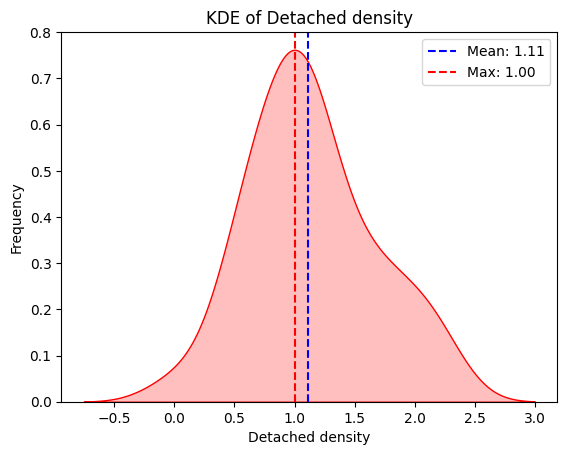

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


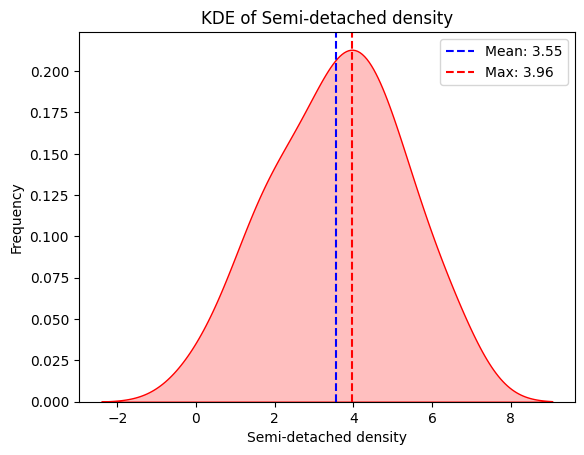

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


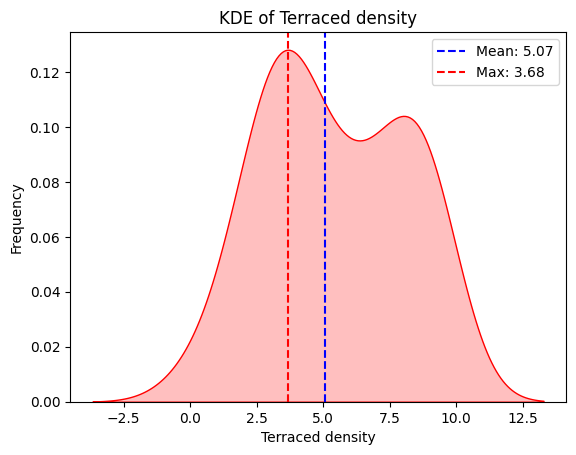

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


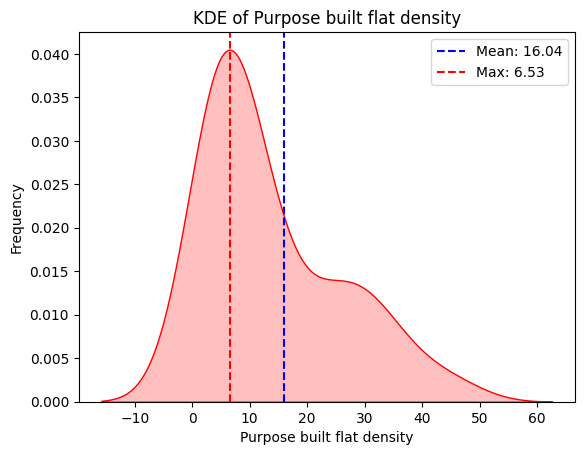

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


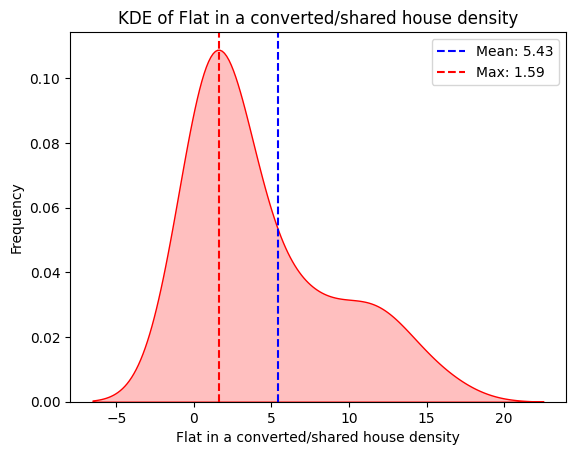

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


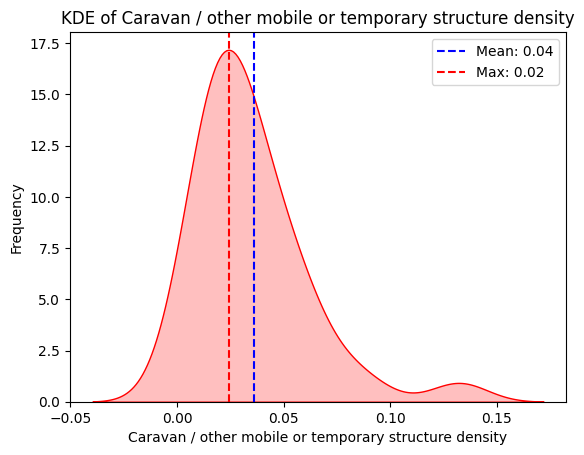

/var/folders/ng/k_cplh696b5gn6zhx9znmp100000gn/T/ipykernel_72112/3005816111.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(regression_data[col], shade=True, color='red')


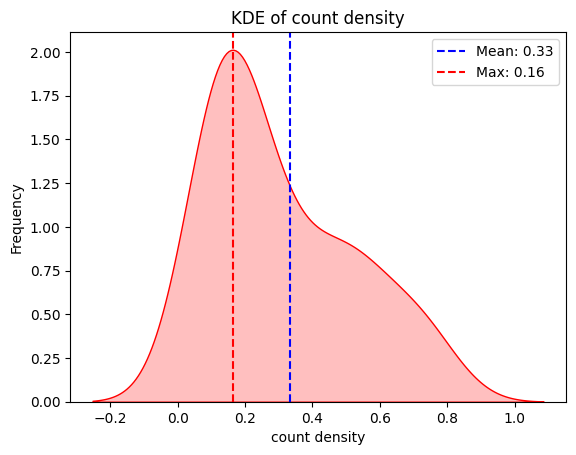

In [164]:
from scipy.stats import gaussian_kde
kde_regression=pd.DataFrame(columns=['mean','max'],index=regression_data.columns)
for col in regression_data.columns:
    kde = gaussian_kde(regression_data[col])
    grid = np.linspace(min(regression_data[col]),max(regression_data[col]),1000)
    grid_value = kde(grid)
    grid_mean = np.sum(grid * grid_value) / np.sum(grid_value)
    grid_max = grid[np.argmax(grid_value)]
    kde_regression.loc[col, 'mean'] = grid_mean
    kde_regression.loc[col, 'max'] = grid_max
    sns.kdeplot(regression_data[col], shade=True, color='red')
    plt.title("KDE of " + str(col))
    plt.axvline(grid_mean, color="blue", linestyle="--", label=f'Mean: {grid_mean:.2f}')
    plt.axvline(grid_max, color="red", linestyle="--", label=f'Max: {grid_max:.2f}')
    plt.xlabel(str(col))
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame() #指定index为df的列名称

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0] #返回行索引
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            print("No features with VIF above the threshold. Exiting.")
            break
    return df


In [84]:
independent_value_float = regression_data.drop(regression_data.columns[-1], axis=1).astype(float)
final_value = drop_column_using_vif_(independent_value_float)

No features with VIF above the threshold. Exiting.


In [166]:
import statsmodels
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.font_manager as fm
fire_dwelling = sm.OLS(endog=regression_data[['count density']], exog=sm.add_constant(final_value)).fit()
fire_dwelling.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          count density   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     196.7
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           2.18e-20
Time:                        14:47:33   Log-Likelihood:                 68.081
No. Observations:                  33   AIC:                            -122.2
Df Residuals:                      26   BIC:                            -111.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                    -0.0605      0.029     -2.050      0.051      -0.121       0.000
Detached density                                          0.0257      0.018      1.443      0.161      -0.011       0.062
Semi-detached density                                     0.0072      0.006      1.166      0.254      -0.005       0.020
Terraced density                                          0.0094      0.003      3.169      0.004       0.003       0.016
Purpose built flat density                                0.0125      0.001     10.327      0.000       0.010       0.015
Flat in a converted/shared house density                  0.0115      0.002      4.904      0.000       0.007       0.016
Caravan / other mobile or temporary structure density     1.1447      0.379      3.024      0.006       0.367       1.923
==============================================================================
Omnibus:                        2.597   Durbin-Watson:                   2.584
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                1.495
Skew:                          -0.482   Prob(JB):                        0.474
Kurtosis:                       3.396   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

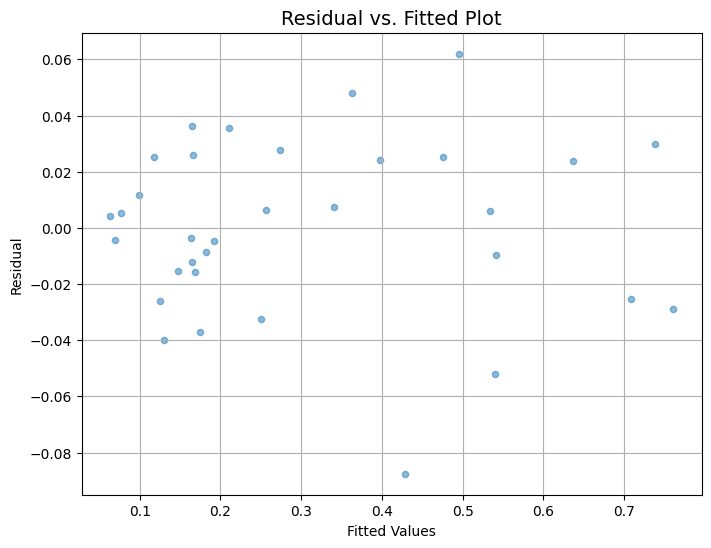

In [86]:
plt.figure(figsize=(8, 6))  
plt.scatter(fire_dwelling.fittedvalues, fire_dwelling.resid, alpha = 0.5, s=20)
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot',fontsize = 14)
# Adding grid lines
plt.grid(True)
plt.show()

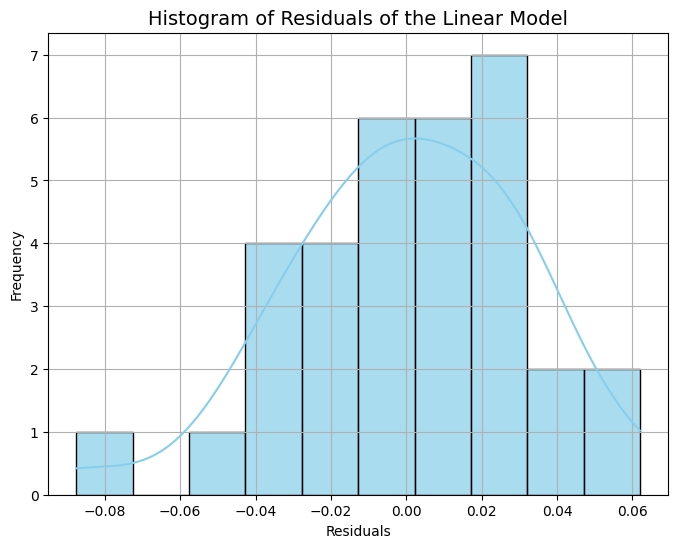

In [87]:
plt.figure(figsize=(8, 6))  
sns.histplot(fire_dwelling.resid, bins=10, color='skyblue', kde=True, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Linear Model',fontsize = 14)
plt.grid(True)
plt.show()

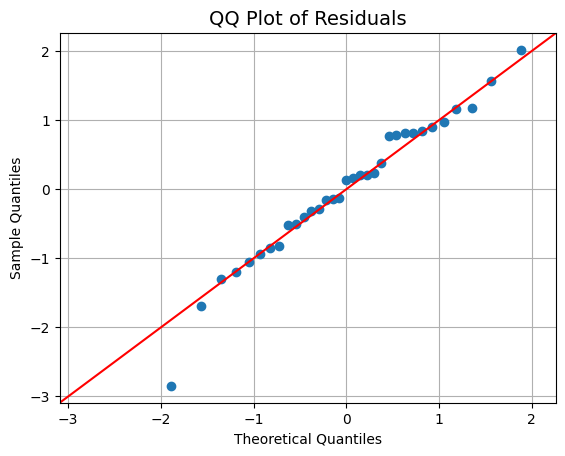

In [88]:
sm.qqplot(fire_dwelling.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals', fontsize=14)
plt.grid(True)
plt.show()

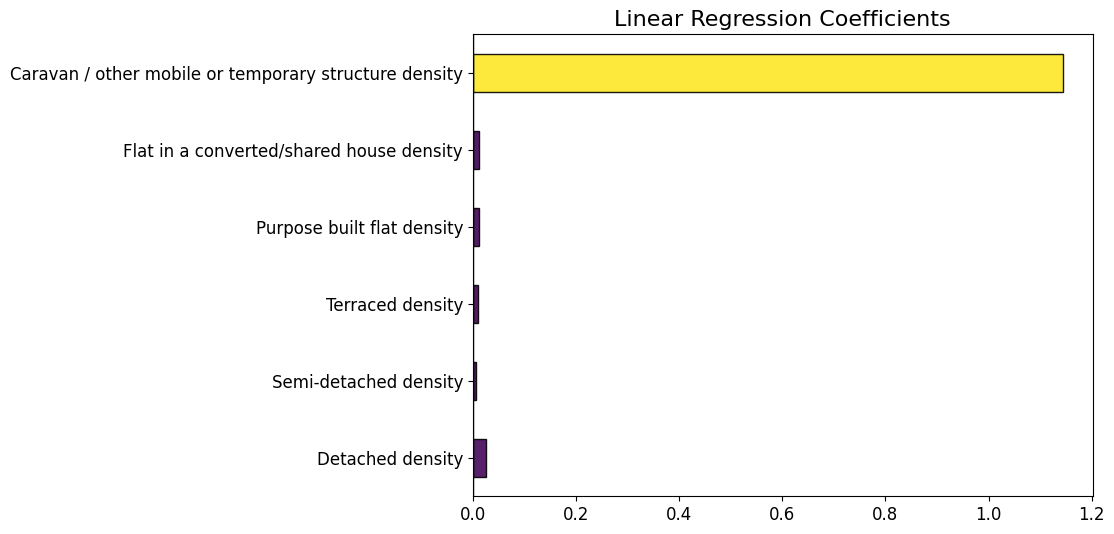

In [90]:
coefficients = fire_dwelling.params.drop('const')
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(coefficients.min(), coefficients.max())
colors = cmap(norm(coefficients))

coefficients.plot(kind='barh', figsize=(8, 6), color=colors, alpha = 0.9, legend=False, edgecolor = 'black')
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.title('Linear Regression Coefficients', fontsize=16)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.show()

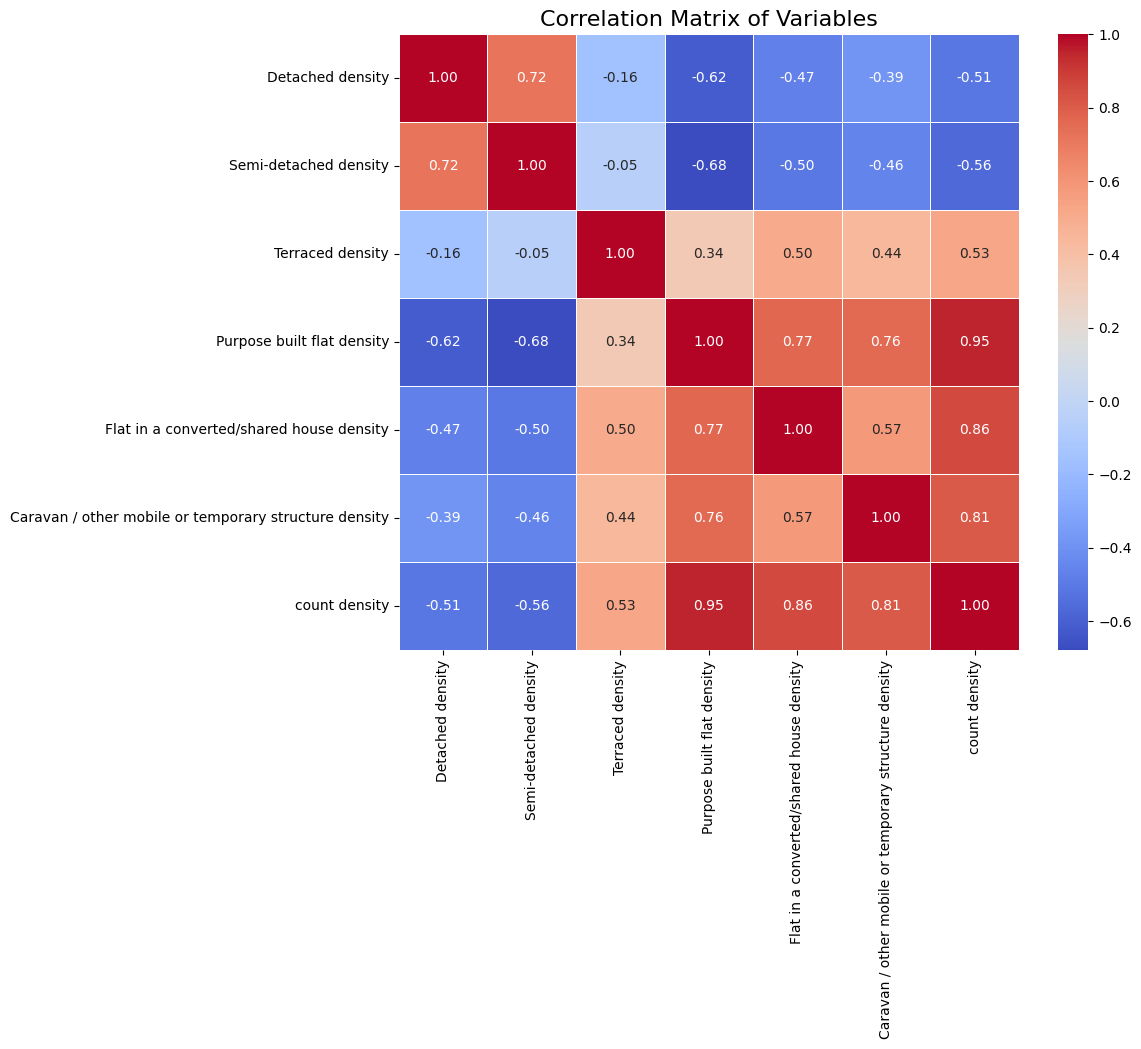

In [131]:
correlation_matrix = regression_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Variables", fontsize=16)

plt.show()


In [157]:
croydon = lfb_incident[(lfb_incident['PropertyCategory']=='Dwelling') & (lfb_incident['IncidentGroup']=='Fire') & (lfb_incident['ProperCase']=="Croydon")][['IncidentNumber', 'PropertyType']]
croydon_storey = croydon[croydon['PropertyType'].str.contains('storey', case=False)].set_index("IncidentNumber").groupby("PropertyType").value_counts().reset_index()
croydon_storey

,PropertyType,count
0,Converted Flat/Maisonette - Up to 2 storeys,113
1,Converted Flat/Maisonettes - 3 or more storeys,119
2,House in Multiple Occupation - 3 or more store...,7
3,House in Multiple Occupation - Up to 2 storeys...,4
4,Licensed House in Multiple Occupation - 3 or m...,17
5,Licensed House in Multiple Occupation - Up to ...,24
6,Purpose Built Flats/Maisonettes - 10 or more s...,53
7,Purpose Built Flats/Maisonettes - 4 to 9 storeys,185
8,Purpose Built Flats/Maisonettes - Up to 3 stor...,335
9,Unlicensed House in Multiple Occupation - 3 or...,3


In [158]:
import jenkspy
from scipy import stats
#breaks = jenkspy.jenks_breaks(croydon_storey['count'], n_classes=3)
croydon_storey['PropertyType'] = croydon_storey['PropertyType'].replace({
    'Converted Flat/Maisonette - Up to 2 storeys ': 'below or equal to 3 storeys', 
    'Converted Flat/Maisonettes - 3 or more storeys': 'above or equal to 3 storeys',
    'House in Multiple Occupation - Up to 2 storeys (not known if licensed) ': 'below or equal to 3 storeys',
    'House in Multiple Occupation - 3 or more storeys (not known if licensed)': 'above or equal to 3 storeys',
    'Licensed House in Multiple Occupation - Up to 2 storeys ':'below or equal to 3 storeys',
    'Licensed House in Multiple Occupation - 3 or more storeys ':'above or equal to 3 storeys',
    'Purpose Built Flats/Maisonettes - Up to 3 storeys ':'below or equal to 3 storeys',
    'Purpose Built Flats/Maisonettes - 4 to 9 storeys ':'above or equal to 3 storeys',
    'Purpose Built Flats/Maisonettes - 10 or more storeys ':'above or equal to 10 storeys',
    'Unlicensed House in Multiple Occupation - Up to 2 storeys ':'below or equal to 3 storeys',
    'Unlicensed House in Multiple Occupation - 3 or more storeys ':'above or equal to 3 storeys',
})
breaks = [0, 100, 300, float('inf')]
croydon_storey['category'] = pd.cut(croydon_storey['count'], bins=breaks, labels=['Low Fire', 'Medium Fire', 'Severe Fire'])
contingency = pd.crosstab(croydon_storey['category'], croydon_storey['PropertyType'])
chi2, p_value, deofreedom, expected_value = stats.chi2_contingency(contingency)


In [168]:
print(p_value)

0.7182472788962329


In [120]:
croydon_storey = pd.get_dummies(croydon_storey, columns=['PropertyType'], drop_first=True)
croydon_storey = croydon_storey.astype(int)
independent = croydon_storey.iloc[:, 1:]
croydon_storey = croydon_storey.iloc[1:,:]
X = sm.add_constant(independent)
y = croydon_storey.iloc[:, 0]
poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                   10
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.284
Date:                Fri, 10 Jan 2025   Deviance:                  -3.0864e-14
Time:                        08:44:55   Pearson chi2:                 2.15e-26
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

/usr/local/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
